## Filtering

In [1]:
import pandas as pd
import numpy as np
import os
import gc
import matplotlib.pyplot as plt

_FOLDER = "data/"
_FOLDER_2 = "figures/"
_FOLDER_3 = "results/"
SAVE_FIGURES = False

from filtering import *

### Original data

In [2]:
drug_curves = pd.read_csv(_FOLDER+"normalised_dose_response_data.csv")

if "Unnamed: 0" in drug_curves:
    drug_curves.drop("Unnamed: 0", axis=1, inplace =True)

col_to_drop = ["per_slope_change_"+str(i) for i in range(8)]+\
            ["slope_" + str(i) for i in range(9)]    
drug_curves.drop(col_to_drop, axis=1, inplace=True)    
    
conc_columns= ["fd_num_"+str(i) for i in range(10)]
response_norm = ['norm_cells_'+str(i) for i in range(10)]
CCL_names = dict(zip(drug_curves["COSMIC_ID"], drug_curves["CELL_LINE_NAME"]))
df= pd.read_csv(_FOLDER+'Drug_Features.csv')
drug_names = dict(zip(df["Drug ID"].values, df["Drug Name"].values))
del df
drug_curves["drug_name"] = drug_curves["DRUG_ID"].map(drug_names)
drug_curves["CCL_name"] = drug_curves["COSMIC_ID"].map(CCL_names)
drug_curves.shape

/Users/Marina/anaconda3/envs/myspark/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (28,30,31,33,34) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(225384, 28)

## Filtering 1:  auc>0.7 and spearman_r<0

In [3]:
%%time
df_filt = AucFitration(drug_curves, conc_columns, response_norm, auc_limit=0.7, save_file_name= "data_with_auc.csv" )
df_filt.to_csv("filtered_data_auc_spearman.csv", index=False)

 85%|████████▌ | 191643/225384 [11:49<02:00, 278.96it/s]/home/marina/anaconda3/lib/python3.7/site-packages/sklearn/metrics/ranking.py:114: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
100%|██████████| 225384/225384 [13:26<00:00, 279.46it/s]


CPU times: user 13min 35s, sys: 2.25 s, total: 13min 38s
Wall time: 13min 33s


In [3]:
df_filt = pd.read_csv("data_with_auc.csv")
df_filt = df_filt[(df_filt["auc"]>0.7) & (df_filt["spearman_r"]<0)].copy()
df_filt.shape

(122642, 30)

In [4]:
df_filt.head()

,CELL_LINE_NAME,COSMIC_ID,DRUG_ID,DRUGID_COSMICID,FOLD_DILUTION,MAX_CONC,fd_num_0,fd_num_1,fd_num_2,fd_num_3,...,norm_cells_4,norm_cells_5,norm_cells_6,norm_cells_7,norm_cells_8,norm_cells_9,drug_name,CCL_name,auc,spearman_r
2,HDQ-P1,1290922,245,245_1290922,2,40.000,0,0.111111,0.222222,0.333333,...,0.839059,0.890866,1.206129,0.605122,0.219697,0.072674,UNC0638,HDQ-P1,0.786979,-0.684848
3,HDQ-P1,1290922,155,155_1290922,2,0.512,0,0.111111,0.222222,0.333333,...,1.234735,1.162228,0.948777,0.888637,0.835206,0.720549,Ponatinib,HDQ-P1,1.012997,-0.624242
5,HDQ-P1,1290922,134,134_1290922,2,16.000,0,0.111111,0.222222,0.333333,...,0.942150,0.869777,0.642170,0.778057,0.472871,0.302965,Etoposide,HDQ-P1,0.826759,-0.878788
6,HDQ-P1,1290922,310,310_1290922,2,5.120,0,0.111111,0.222222,0.333333,...,1.058269,1.011829,1.030699,0.938903,0.822977,0.743958,YM201636,HDQ-P1,0.996959,-0.696970
7,HDQ-P1,1290922,306,306_1290922,2,10.240,0,0.111111,0.222222,0.333333,...,1.075626,0.967346,1.061919,1.024397,1.020519,0.788487,Fedratinib,HDQ-P1,1.008146,-0.078788


Responses above 1: 75014


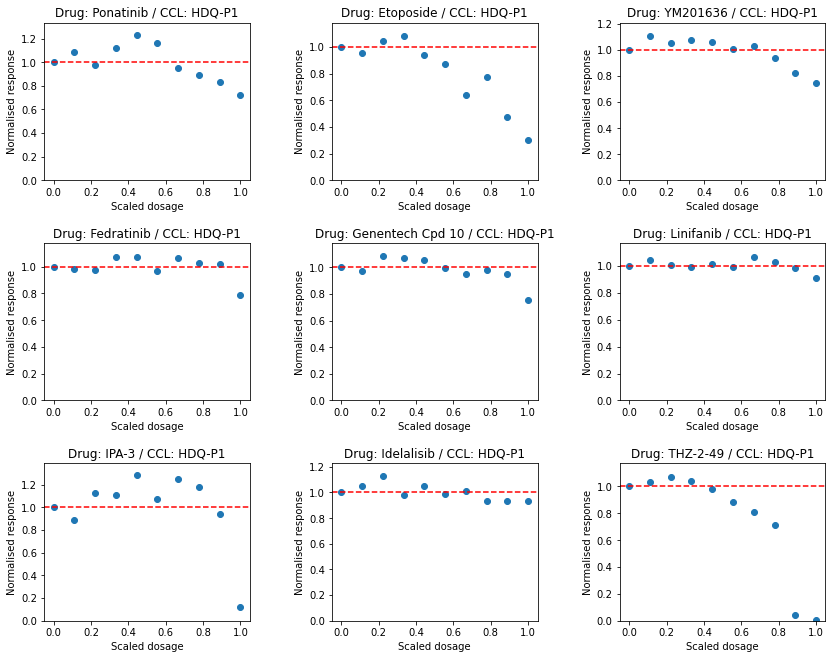

In [5]:
high_resp_data = FindHighResponses(df_filt, response_norm)
print("Responses above 1:", high_resp_data.shape[0])

df = high_resp_data
ShowResponseCurves(df, plots_in_row=3, plots_in_column=3, \
                   x_columns=conc_columns, y_columns=response_norm, indexes=df.index[:9],
                  drug_dict = drug_names, CCL_dict = CCL_names, upper_limit=1)

## Bad data left after filtering 1

Ascending points: 20081


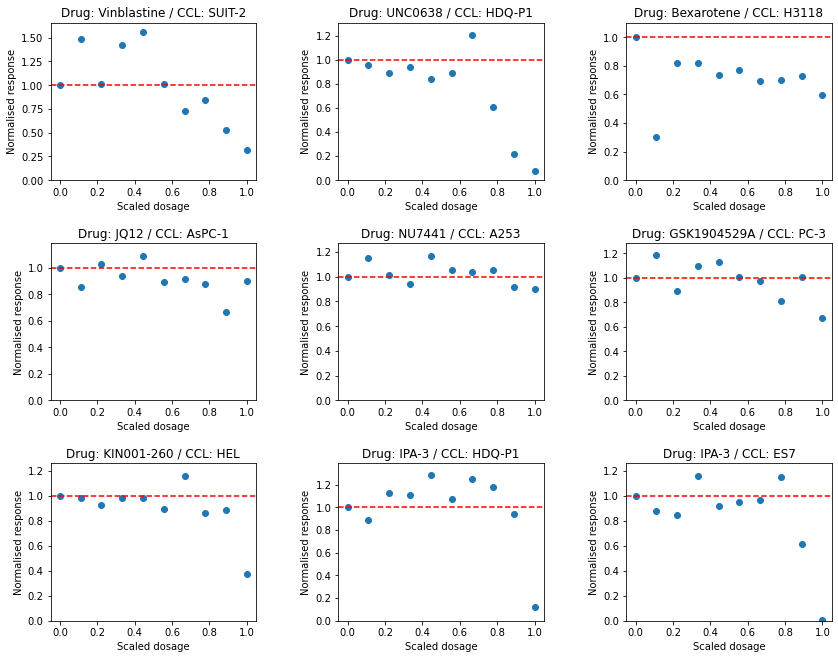

In [6]:
ascend_data = FindAscendingData(df_filt, response_norm, middle_points_limit=-0.2)
print("Ascending points:", ascend_data.shape[0])

df = ascend_data
ShowResponseCurves(df, plots_in_row=3, plots_in_column=3, \
                   x_columns=conc_columns, y_columns=response_norm, indexes=df.index[:9],
                  drug_dict = drug_names, CCL_dict = CCL_names, upper_limit=1)

## Filtering 2: 3 stage filtering as in MSc project

In [7]:
df_filt_123 = FilteringSigmoidCurves(drug_curves, filtering_scenario=[1,2,3], \
                        response_columns = response_norm, \
                        first_points_lower_limit = 0.8, last_points_upper_limit = 0.4)

Original dataset: (225384, 28)
1st filtration (Ensure that all the response are less than 1): Filtered dataset: (63325, 28)
2d filtration (Ensure that first and last points form plateus): Filtered dataset: (6321, 30)
3d stage filtration (Specified location of the plateus): Filtered dataset: (2776, 30)


## Bad data left after filtering 2

Ascending points: 57


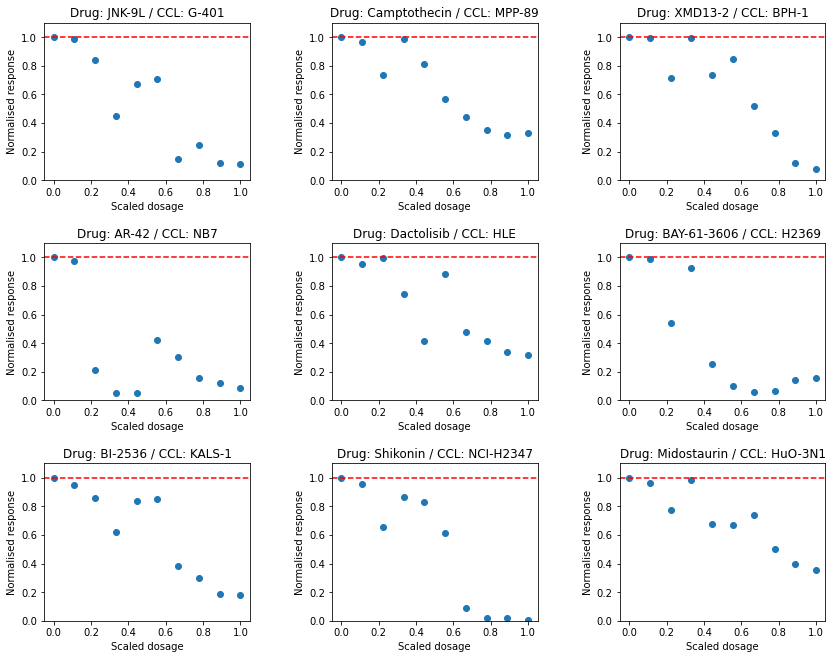

In [8]:
ascend_data = FindAscendingData(df_filt_123, response_norm, middle_points_limit=-0.2)
print("Ascending points:", ascend_data.shape[0])

df = ascend_data
ShowResponseCurves(df, plots_in_row=3, plots_in_column=3, \
                   x_columns=conc_columns, y_columns=response_norm, indexes=df.index[:9],
                  drug_dict = drug_names, CCL_dict = CCL_names, upper_limit=1)

## Filtering 3: 4 stage filtering

In [9]:
df_filt_1234 = FilteringSigmoidCurves(drug_curves, filtering_scenario=[1,2,3,4], \
                        response_columns = response_norm, \
                        first_points_lower_limit = 0.8, last_points_upper_limit = 0.4, 
                         middle_points_limit = -0.2)

Original dataset: (225384, 28)
1st filtration (Ensure that all the response are less than 1): Filtered dataset: (63325, 28)
2d filtration (Ensure that first and last points form plateus): Filtered dataset: (6321, 30)
3d stage filtration (Specified location of the plateus): Filtered dataset: (2776, 30)
4th stage filtration (Cut off high ancedent points): Filtered dataset: (2719, 30)


In [10]:
df_filt_1234 = FilteringSigmoidCurves(drug_curves, filtering_scenario=[1,2,3,4], \
                        response_columns = response_norm, \
                        first_points_lower_limit = 0.8, last_points_upper_limit = 0.4, 
                         middle_points_limit = -0.1)

Original dataset: (225384, 28)
1st filtration (Ensure that all the response are less than 1): Filtered dataset: (63325, 28)
2d filtration (Ensure that first and last points form plateus): Filtered dataset: (6321, 30)
3d stage filtration (Specified location of the plateus): Filtered dataset: (2776, 30)
4th stage filtration (Cut off high ancedent points): Filtered dataset: (2600, 30)


## Complement Filtering 1 (with auc and spearman) with cutting off outliers

In [11]:
df_filt.shape

(122642, 30)

In [12]:
df_filt_outl_02 = CutOffOutliers(df_filt, response_norm, middle_points_limit = -0.2)
df_filt_outl_02.shape

(102561, 30)

In [13]:
df_filt_outl_01= CutOffOutliers(df_filt, response_norm, middle_points_limit = -0.1)
df_filt_outl_01.shape

(72581, 30)

# Conclusion - amount of data left

In [14]:
print("MSc filtering (3 stages for perfect sigmoid):", df_filt_123.shape[0])
print("4 stage filtering (with cutting off outliers):", df_filt_1234.shape[0])

MSc filtering (3 stages for perfect sigmoid): 2776
4 stage filtering (with cutting off outliers): 2600


In [15]:
print("Filtering with auc>0.7 and spearman<0:", df_filt.shape[0])
print("Filtering with auc>0.7 and spearman<0 & cutting off outliers:", df_filt_outl_02.shape[0])

Filtering with auc>0.7 and spearman<0: 122642
Filtering with auc>0.7 and spearman<0 & cutting off outliers: 102561


## Some data left after Filtering with auc>0.7 and spearman<0 & cutting off outliers

(102561, 30)
Responses above 1: 59284


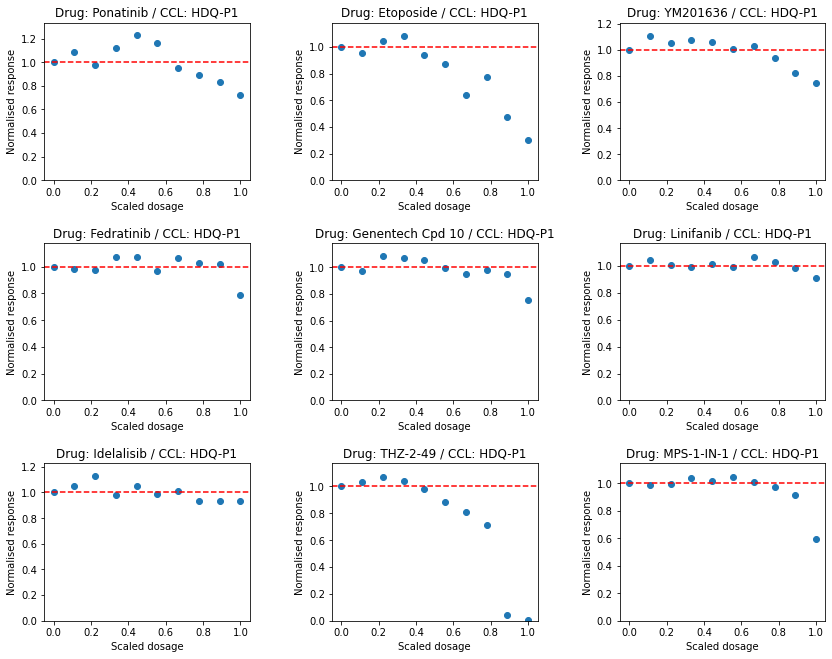

In [16]:
print(df_filt_outl_02.shape)
high_resp_data = FindHighResponses(df_filt_outl_02, response_norm)
print("Responses above 1:", high_resp_data.shape[0])

df = high_resp_data
ShowResponseCurves(df, plots_in_row=3, plots_in_column=3, \
                   x_columns=conc_columns, y_columns=response_norm, indexes=df.index[:9],
                  drug_dict = drug_names, CCL_dict = CCL_names, upper_limit=1)

## Leave the data where significant final response was observed

Filtered data: 102561
Good responses 41613


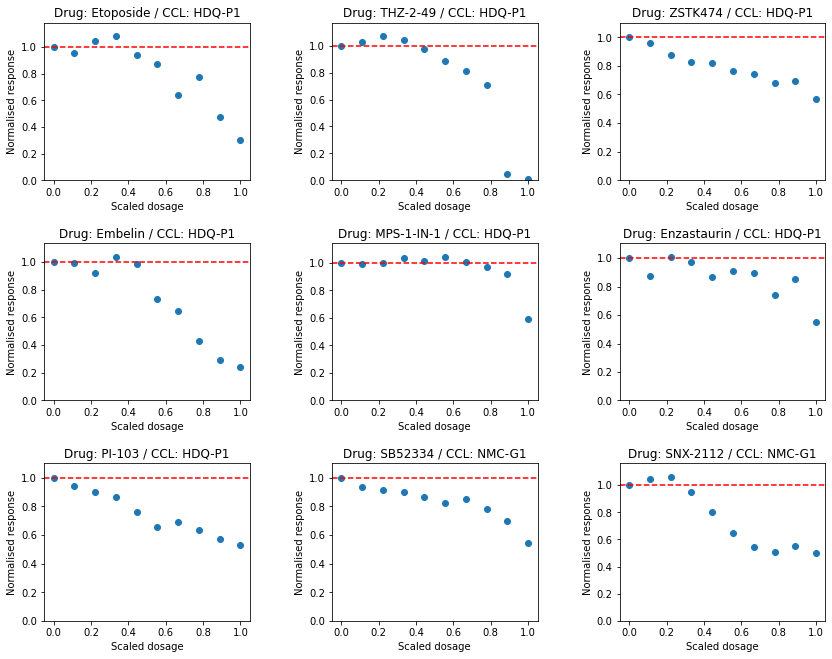

In [17]:
print("Filtered data:", df_filt_outl_02.shape[0])
df_good_resp_06 = FilterGoodResponse(df_filt_outl_02, response_norm, final_response_limit=0.6)
print("Good responses", df_good_resp_06.shape[0])

df = df_good_resp_06
ShowResponseCurves(df, plots_in_row=3, plots_in_column=3, \
                   x_columns=conc_columns, y_columns=response_norm, indexes=df.index[:9],
                  drug_dict = drug_names, CCL_dict = CCL_names, upper_limit=1)

Filtered data: 102561
Good responses 24164


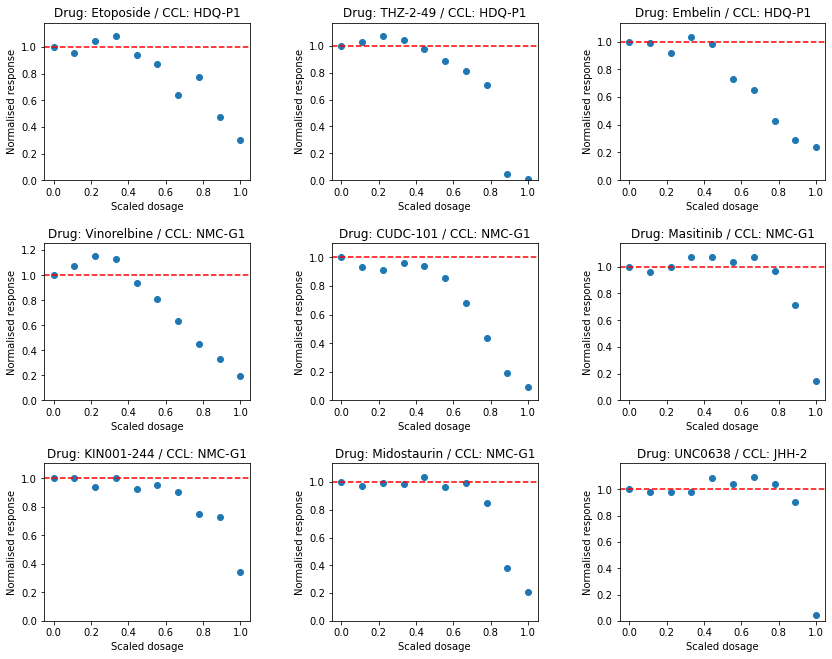

In [18]:
print("Filtered data:", df_filt_outl_02.shape[0])
df_good_resp_04 = FilterGoodResponse(df_filt_outl_02, response_norm, final_response_limit=0.4)
print("Good responses", df_good_resp_04.shape[0])

df = df_good_resp_04
ShowResponseCurves(df, plots_in_row=3, plots_in_column=3, \
                   x_columns=conc_columns, y_columns=response_norm, indexes=df.index[:9],
                  drug_dict = drug_names, CCL_dict = CCL_names, upper_limit=1)

Filtered data: 102561
Good responses 12169


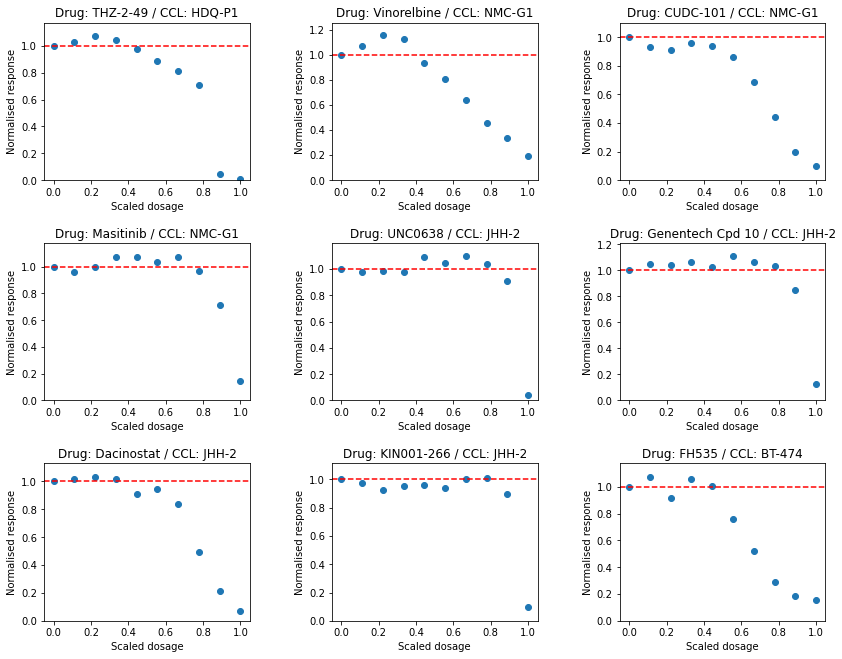

In [19]:
print("Filtered data:", df_filt_outl_02.shape[0])
df_good_resp_02 = FilterGoodResponse(df_filt_outl_02, response_norm, final_response_limit=0.2)
print("Good responses", df_good_resp_02.shape[0])

df = df_good_resp_02
ShowResponseCurves(df, plots_in_row=3, plots_in_column=3, \
                   x_columns=conc_columns, y_columns=response_norm, indexes=df.index[:9],
                  drug_dict = drug_names, CCL_dict = CCL_names, upper_limit=1)

Filtered data: 72581
Good responses 9287


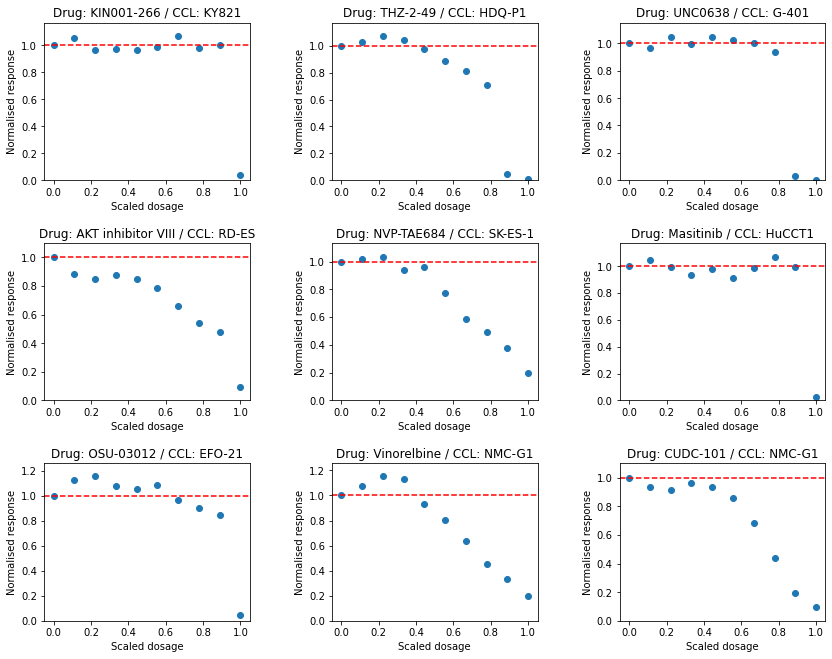

In [20]:
print("Filtered data:", df_filt_outl_01.shape[0])
df_good_resp_02_2 = FilterGoodResponse(df_filt_outl_01, response_norm, final_response_limit=0.2)
print("Good responses", df_good_resp_02_2.shape[0])

df = df_good_resp_02_2
ShowResponseCurves(df, plots_in_row=3, plots_in_column=3, \
                   x_columns=conc_columns, y_columns=response_norm, indexes=df.index[:9],
                  drug_dict = drug_names, CCL_dict = CCL_names, upper_limit=1)

In [22]:
df_filt.to_csv(_FOLDER_3+"/filt_auc.csv", index=False)

In [21]:
df_good_resp_02.to_csv(_FOLDER_3 + "/filt_auc_02.csv", index=False) 
df_good_resp_04.to_csv(_FOLDER_3 + "/filt_auc_04.csv", index=False) 
df_good_resp_06.to_csv(_FOLDER_3 + "/filt_auc_06.csv", index=False) 

In [23]:
df_filt_123.to_csv(_FOLDER_3 + "/filt_123.csv",index=False)
df_filt_1234.to_csv(_FOLDER_3 + "/filt_1234.csv",index=False)